In [1]:
# What version of Python do you have?
import sys

import torch
import pandas as pd
import sklearn as sk

print(f"PyTorch Version: {torch.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if torch.cuda.is_available() else "NOT AVAILABLE")

PyTorch Version: 1.9.0+cu102

Python 3.8.10 (default, May 19 2021, 13:12:57) [MSC v.1916 64 bit (AMD64)]
Pandas 1.3.1
Scikit-Learn 0.24.2
GPU is available


In [2]:
import os
dir = os.path.abspath(os.curdir)
dir

'C:\\Users\\MSI_NOTEBOOK_PC\\code'

In [2]:
import pickle
import numpy as np
#from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [3]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [4]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [5]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [7]:
dir

'C:\\Users\\MSI_NOTEBOOK_PC\\code'

In [6]:
TRAIN_DIR = Path('journey-springfield/train/simpsons_dataset/')
TEST_DIR = Path('journey-springfield/testset/')
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
print(TRAIN_DIR,TEST_DIR)
print(train_val_files[len(train_val_files)-11:],'\n\n',test_files[:10])


journey-springfield\train\simpsons_dataset journey-springfield\testset
[WindowsPath('journey-springfield/train/simpsons_dataset/waylon_smithers/pic_0170.jpg'), WindowsPath('journey-springfield/train/simpsons_dataset/waylon_smithers/pic_0171.jpg'), WindowsPath('journey-springfield/train/simpsons_dataset/waylon_smithers/pic_0172.jpg'), WindowsPath('journey-springfield/train/simpsons_dataset/waylon_smithers/pic_0173.jpg'), WindowsPath('journey-springfield/train/simpsons_dataset/waylon_smithers/pic_0174.jpg'), WindowsPath('journey-springfield/train/simpsons_dataset/waylon_smithers/pic_0175.jpg'), WindowsPath('journey-springfield/train/simpsons_dataset/waylon_smithers/pic_0176.jpg'), WindowsPath('journey-springfield/train/simpsons_dataset/waylon_smithers/pic_0177.jpg'), WindowsPath('journey-springfield/train/simpsons_dataset/waylon_smithers/pic_0178.jpg'), WindowsPath('journey-springfield/train/simpsons_dataset/waylon_smithers/pic_0179.jpg'), WindowsPath('journey-springfield/train/simpsons_

In [7]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [8]:
val_dataset = SimpsonsDataset(val_files, mode='val')

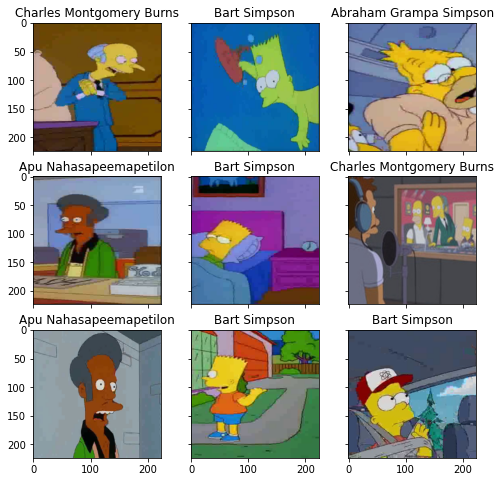

In [11]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [9]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    for inputs, labels in train_loader:

        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [10]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [11]:
def train(train_files, val_files, model, epochs, batch_size, opt, criterion, exp_lr_scheduler):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        #opt = torch.optim.Adam(model.classifier.parameters())
        #criterion = nn.CrossEntropyLoss()
        exp_lr_scheduler.step()
        for epoch in range(epochs):
            
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [12]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [17]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

In [14]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [13]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

lets try AlexNet

In [21]:
TRAIN_DIR

WindowsPath('journey-springfield/train/simpsons_dataset')

In [16]:
import os
root=TRAIN_DIR
dirlist = [ item for item in os.listdir(root) if os.path.isdir(os.path.join(root, item)) ]
print(len(dirlist))


42


In [17]:
import os
from tqdm.autonotebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
model = models.alexnet(pretrained=True)

In [24]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [25]:
num_features = 9216

In [26]:
for i, child in enumerate(model.children()):
    print(i, child)

0 Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)
1 AdaptiveAvgPool2d(output_size=(6, 6))
2 Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in

In [27]:
for param in model.parameters():
    param.requires_grad = False
model.classifier = nn.Linear(num_features,42)

# Использовать ли GPU
model = model.to(DEVICE)

# В качестве cost function используем кросс-энтропию
#loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора - стохастический градиентный спуск
#optimizer_ft = optim.Adam(model.classifier.parameters())#, lr=1e-3)
for param in model.parameters():
    print(param.requires_grad)
# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

False
False
False
False
False
False
False
False
False
False
True
True


In [28]:
history = train(train_dataset, val_dataset, model=model, epochs=2, batch_size=64)


epoch:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\MSI_NOTEBOOK_PC\miniconda3\envs\torch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


loss 1.8274206173132161

Epoch 001 train_loss: 1.8274     val_loss 1.2744 train_acc 0.6521 val_acc 0.7476
loss 0.3770288268246691

Epoch 002 train_loss: 0.3770     val_loss 1.6954 train_acc 0.8973 val_acc 0.7027


In [30]:
torch.save(model.state_dict(), 'AlexNet_sim.pth')

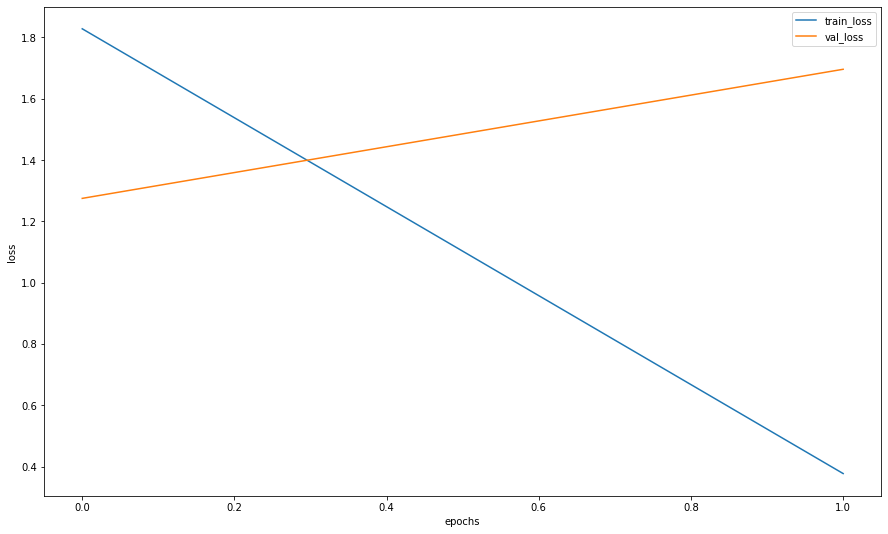

In [31]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

okey its bad lets try another model

In [32]:
model_extractor = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\MSI_NOTEBOOK_PC/.cache\torch\hub\checkpoints\vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [33]:
model_extractor

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [34]:

for param in model_extractor.parameters():
    param.requires_grad = False

    
model_extractor.classifier = nn.Linear(25088, 42)
model_extractor = model_extractor.cuda()


loss_fn = nn.CrossEntropyLoss()


optimizer = optim.SGD(model_extractor.classifier.parameters(), lr=0.001, momentum=0.9)


exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [39]:

history = train(train_dataset, val_dataset, model=model_extractor, epochs=2, batch_size=64, opt=optimizer,\
                criterion=loss_fn, exp_lr_scheduler=exp_lr_scheduler)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\MSI_NOTEBOOK_PC\miniconda3\envs\torch\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


loss 1.4523981506865953

Epoch 001 train_loss: 1.4524     val_loss 0.9676 train_acc 0.6321 val_acc 0.7585
loss 0.39610498813096334

Epoch 002 train_loss: 0.3961     val_loss 0.8184 train_acc 0.9153 val_acc 0.7944


it look beter lets change step_size to 4 and epochs to 11 and activate all layers

go

In [65]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [22]:
model_extractor_v3 = models.vgg16(pretrained=True)

    
model_extractor_v3.classifier = nn.Linear(25088, 42)
model_extractor_v3 = model_extractor_v3.cuda()


loss_fn = nn.CrossEntropyLoss()


optimizer = torch.optim.Adam(params=[
        {"params": model_extractor_v3.classifier.parameters(), "lr": 1e-4,},
        {"params": model_extractor_v3.features.parameters(), "lr": 1e-5,}
    ], 
    lr=1e-4
)


exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [23]:
history = train(train_dataset, val_dataset, model=model_extractor_v3, epochs=11, batch_size=32, opt=optimizer,\
                criterion=loss_fn, exp_lr_scheduler=exp_lr_scheduler)

epoch:   0%|          | 0/11 [00:00<?, ?it/s]

loss 1.0268096834472413

Epoch 001 train_loss: 1.0268     val_loss 0.3928 train_acc 0.7392 val_acc 0.8995
loss 0.06986322071842498

Epoch 002 train_loss: 0.0699     val_loss 0.4199 train_acc 0.9852 val_acc 0.8938
loss 0.011431560009633909

Epoch 003 train_loss: 0.0114     val_loss 0.4476 train_acc 0.9989 val_acc 0.9119
loss 0.0032783195441269414

Epoch 004 train_loss: 0.0033     val_loss 0.5077 train_acc 0.9996 val_acc 0.9087
loss 0.0035015995600758596

Epoch 005 train_loss: 0.0035     val_loss 0.4804 train_acc 0.9997 val_acc 0.9123
loss 0.000782424333726391

Epoch 006 train_loss: 0.0008     val_loss 0.4980 train_acc 0.9999 val_acc 0.9136
loss 0.0015979588308859549

Epoch 007 train_loss: 0.0016     val_loss 0.5040 train_acc 0.9999 val_acc 0.9135
loss 0.0010187850140905624

Epoch 008 train_loss: 0.0010     val_loss 0.4942 train_acc 0.9999 val_acc 0.9159
loss 0.0007254278152011968

Epoch 009 train_loss: 0.0007     val_loss 0.5202 train_acc 0.9999 val_acc 0.9161
loss 0.008219380193779435


In [24]:
torch.save(model_extractor_v3.state_dict(), 'vgg16_v3_sim.pth')

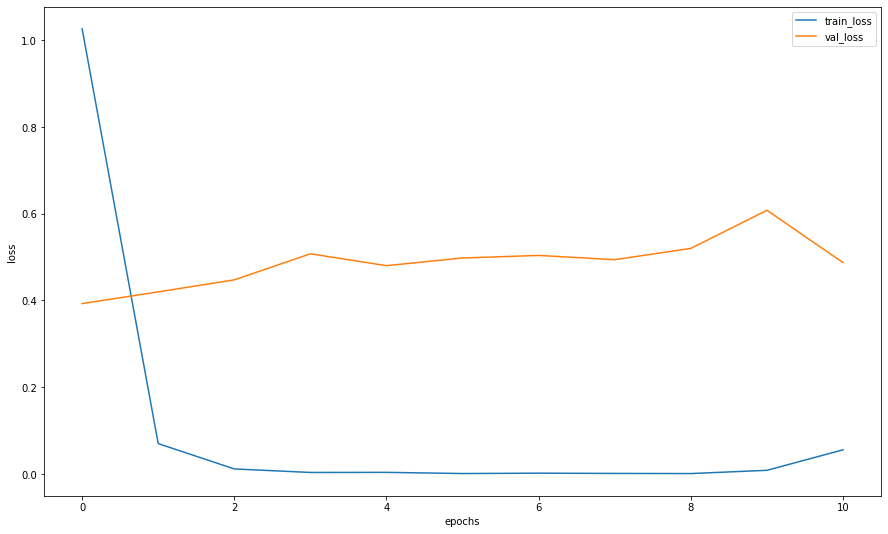

In [25]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

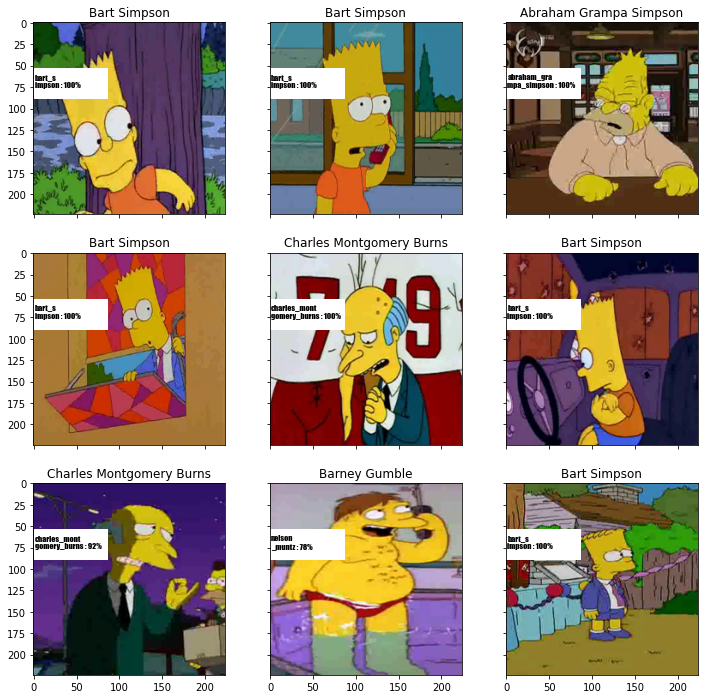

In [31]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model_extractor_v3, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')